In [141]:
import numpy as np
import scipy as sc
import neo
import quantities as pq
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os
from copy import copy

In [2]:
sys.path.append('../pipeline/')
from settings import output_path
from utils import AnalogSignal2ImageSequence
output_path = '/home/rgutzen/ProjectsData/wave_analysis_pipeline/LENS/'
data_path = os.path.join(output_path, 'stage04_wavefront_detection', 'optical_flow', 'waves.nix')

with neo.NixIO(data_path) as io:
        block = io.read_block()

In [3]:
# block.segments[0].analogsignals[0] = block.segments[0].analogsignals[0].time_slice(0*pq.s, 1*pq.s)
block = AnalogSignal2ImageSequence(block)
vec_frames = block.segments[0].imagesequences[1].as_array()
frames = block.segments[0].imagesequences[0].as_array()

In [63]:
def plot_frame(i=1, heatmap=True, vector_field=True, ax=None, skip_step=3):
    vec_frame = vec_frames[i]
    frame = frames[i]
    indices = np.where(np.isfinite(frame))
    dim_x, dim_y = frame.shape

    plot_frame = vec_frame[indices]
    pad_plot_frame = np.pad(plot_frame, (0, skip_step - plot_frame.size%skip_step), 
                            mode='constant', constant_values=np.NaN)
    avg_plot_frame = np.nanmean(pad_plot_frame.reshape(-1, skip_step), axis=1)
    
    fig, ax = plt.subplots(figsize=(15,12))
    if heatmap:
        vmin = np.nanmin(frames)
        vmax = np.nanmax(frames)
        cmap = plt.get_cmap('viridis')
        img = ax.imshow(frame, interpolation='nearest',
                        cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(img, ax=ax)
    
    if vector_field:
        ax.quiver(np.arange(dim_y)[::skip_step],
                  np.arange(dim_x)[::skip_step],
                  np.real(vec_frame[::skip_step,::skip_step]),
                  -np.imag(vec_frame[::skip_step,::skip_step]))
    return ax

In [226]:
[i for i in range(2,7,1)]

[2, 3, 4, 5, 6]

In [321]:
from shapely.geometry import LineString

def get_line_intersections(contourA, contourB):
    points = []
    for path in contourA.collections[0].get_paths():
        lineA = LineString(path.vertices)
        
        for path in contourB.collections[0].get_paths():
            lineB = LineString(path.vertices)
            intersection = lineA.intersection(lineB)

            if not intersection.is_empty:
                if intersection.type == 'MultiPoint':
                    points += [(i.x, i.y) for i in intersection]
                elif intersection.type == 'Point':
                    points += [(intersection.x, intersection.y)]
    return points

In [327]:
def jacobian(xy, fA, fB):
    # dA/dx  dA/dy
    # dB/dx  dB/dy
    x, y = int(xy[0]), int(xy[1])
    J = np.zeros((2,2))
    J[0,0] = fA[x+1, y]   - fA[x, y]    
    J[0,1] = fA[x  , y+1] - fA[x, y]    
    J[1,0] = fB[x+1, y]   - fB[x, y]    
    J[1,1] = fB[x  , y+1] - fB[x, y]
    return J


def classify_critical_point(J):
    t = np.trace(J)
    det = np.linalg.det(J)
    if det > 0:
        if t**2 > 4*det:
            if t > 0 :
                return 'node stable'
            else: 
                return 'node unstable'
        else:
            if t > 0:
                return 'focus stable'
            else:
                return 'focus unstable'
    else:
        return 'saddle'
    

/home/rgutzen/anaconda3/envs/wavescalephant_dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


saddle
focus stable
node stable
focus unstable
saddle
focus stable
focus stable
saddle
node unstable
saddle
focus stable
focus stable
saddle
node stable
saddle
node stable


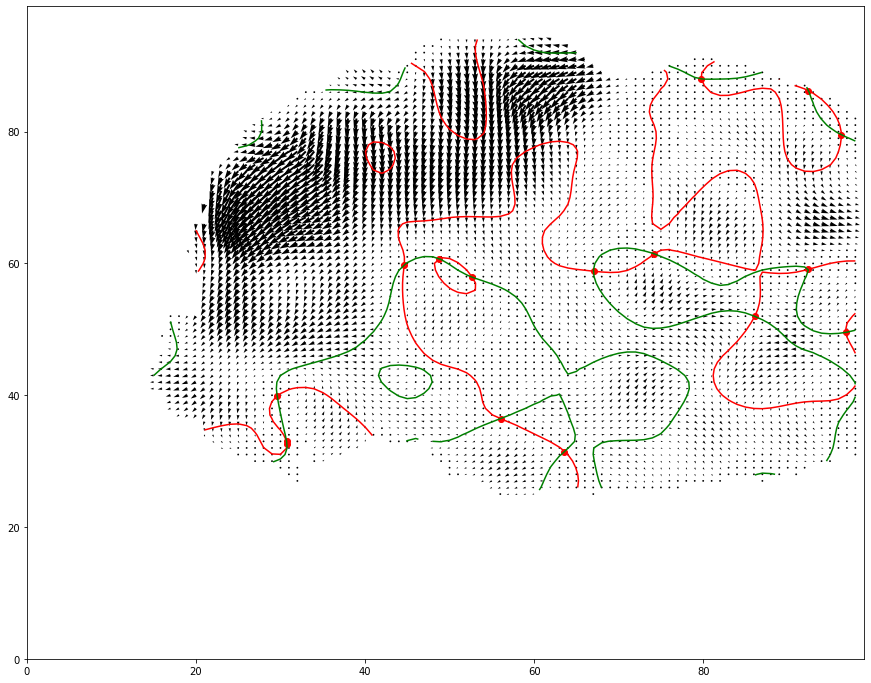

In [328]:
t = 1
ax = plot_frame(t, heatmap=False, skip_step=1)

dim_t, dim_x, dim_y = vec_frames.shape
X, Y = np.meshgrid(np.arange(dim_x), np.arange(dim_y))
ZR = np.real(vec_frames[t])
contourR = ax.contour(X,Y, ZR, levels=[0], colors='r')
ZI = np.imag(vec_frames[t])
contourI = ax.contour(X,Y, ZI, levels=[0], colors='g')

# # Option 1
# x, y = get_potential_intersections(contourR, contourI, dim_x, dim_y, dxy=2)
# xy = get_intersections(x, y, ZR.T, ZI.T, dxy=2)
# xy = merge_close_points(xy)

# # Option 2

xy = get_line_intersections(contourR, contourI)

for xyi in xy:
    ax.scatter(xyi[0], xyi[1], color='r')
    j = jacobian(xyi, ZR.T, ZI.T)
    print(classify_critical_point(j))
    

# ax.set_xlim((60, 80))
# ax.set_ylim((40, 60))
plt.savefig('/home/rgutzen/Sciebo/own/WP3_wavescalephant/critcial_point_search2.png')

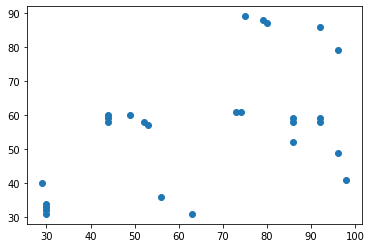